In [26]:
# %%
%load_ext autoreload
%autoreload 2

# %%
import time
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
from os.path import join
import pickle as pkl
import time
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from core.img_patch_stats_analysis_lib import compute_crossing_points, sweep_and_create_sample_store, process_img_mean_cov_statistics,\
     process_patch_mean_cov_statistics, plot_variance_trajectories, plot_mean_deviation_trajectories, \
     harmonic_mean, smooth_and_find_threshold_crossing
from core.trajectory_convergence_lib import analyze_and_plot_variance
from circuit_toolkit.plot_utils import saveallforms
from circuit_toolkit.plot_utils import to_imgrid

# %%
# from core.edm_dataset import load_dataset
def load_dataset(dataset_name, normalize=True):
    import sys
    import torchvision
    import torchvision.transforms as transforms
    sys.path.append("/n/home12/binxuwang/Github/edm")
    from training.dataset import TensorDataset, ImageFolderDataset
    edm_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Datasets/EDM_datasets/datasets"
    word_dataset_root = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/wordnet_render_dataset"
    if dataset_name == "FFHQ":
        edm_ffhq64_path = join(edm_dataset_root, "ffhq-64x64.zip")
        dataset = ImageFolderDataset(edm_ffhq64_path)
        imgsize = 64
        Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    elif dataset_name == "AFHQ":
        edm_afhq_path = join(edm_dataset_root, "afhqv2-64x64.zip")
        dataset = ImageFolderDataset(edm_afhq_path)
        imgsize = 64
        Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    elif dataset_name == "CIFAR":
        edm_cifar_path = join(edm_dataset_root, "cifar10-32x32.zip")
        dataset = ImageFolderDataset(edm_cifar_path)
        imgsize = 32
        Xtsr_raw = torch.stack([torch.from_numpy(dataset[i][0]) for i in range(len(dataset))]) / 255.0
    elif dataset_name == "MNIST":
        dataset = torchvision.datasets.MNIST(root='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Data', 
                            train=True, download=True, 
                            transform=transforms.Compose([transforms.ToTensor(), transforms.Resize((32, 32))]))
        imgsize = 32
        Xtsr_raw = torch.stack([dataset[i][0] for i in range(len(dataset))])
        # mnist_Xtsr = torch.stack([mnist_dataset[i][0] for i in range(len(mnist_dataset))])
        # print(mnist_Xtsr.shape) # 60000 x 32 x 32
        # Xtsr = (mnist_Xtsr.to(device) - 0.5) / 0.5
    elif dataset_name == "MNIST28":
        dataset = torchvision.datasets.MNIST(root='/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Data', 
                            train=True, download=True, 
                            transform=transforms.Compose([transforms.ToTensor(), ]))
        imgsize = 28
        Xtsr_raw = torch.stack([dataset[i][0] for i in range(len(dataset))])
    elif dataset_name == "afhq-32x32":
        Xtsr_raw = torch.load(join(word_dataset_root, "afhq-32x32.pt"))
        imgsize = 32
    elif dataset_name == "ffhq-32x32":
        Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-32x32.pt"))
        imgsize = 32
    elif dataset_name == "ffhq-32x32-fix_words":
        Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-32x32-fixed_text.pt"))
        imgsize = 32
    elif dataset_name == "ffhq-32x32-random_word_jitter":
        Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-32x32-random_word_jitter1-4.pt"))
        imgsize = 32
    print(f"{dataset_name} dataset: {Xtsr_raw.shape}")
    print(f"Raw value range" , (Xtsr_raw[0].max().item()), (Xtsr_raw[0].min().item()))
    if normalize:
        print("Normalizing dataset to [-1.0, 1.0]")
        Xtsr = (Xtsr_raw - 0.5) / 0.5
    else:
        Xtsr = Xtsr_raw
    return Xtsr, imgsize

#%%
def test_dataset_loading():
    """
    Test function to verify all datasets are loadable.
    This function attempts to load each dataset and prints basic information about it.
    """
    datasets_to_test = [
        "FFHQ", 
        "AFHQ", 
        "CIFAR", 
        "MNIST", 
        "afhq-32x32", 
        "ffhq-32x32", 
        "ffhq-32x32-fix_words", 
        "ffhq-32x32-random_word_jitter"
    ]
    
    results = {}
    
    print("Testing dataset loading...")
    print("-" * 50)
    
    for dataset_name in datasets_to_test:
        print(f"Loading dataset: {dataset_name}")
        try:
            start_time = time.time()
            Xtsr, imgsize = load_dataset(dataset_name, normalize=True)
            load_time = time.time() - start_time
            
            results[dataset_name] = {
                "status": "Success",
                "shape": Xtsr.shape,
                "imgsize": imgsize,
                "min_value": Xtsr.min().item(),
                "max_value": Xtsr.max().item(),
                "load_time": f"{load_time:.2f} seconds"
            }
            
            print(f"  ✓ Successfully loaded {dataset_name}")
            print(f"    Shape: {Xtsr.shape}")
            print(f"    Image size: {imgsize}x{imgsize}")
            print(f"    Value range: [{Xtsr.min().item():.2f}, {Xtsr.max().item():.2f}]")
            print(f"    Load time: {load_time:.2f} seconds")
            
        except Exception as e:
            results[dataset_name] = {
                "status": "Failed",
                "error": str(e)
            }
            print(f"  ✗ Failed to load {dataset_name}")
            print(f"    Error: {str(e)}")
        
        print("-" * 50)
    
    # Summary
    print("\nDataset Loading Summary:")
    print("-" * 50)
    success_count = sum(1 for result in results.values() if result["status"] == "Success")
    print(f"Successfully loaded: {success_count}/{len(datasets_to_test)} datasets")
    
    for dataset_name, result in results.items():
        status_symbol = "✓" if result["status"] == "Success" else "✗"
        print(f"{status_symbol} {dataset_name}: {result['status']}")
    
    return results

# Uncomment the line below to run the test
# test_results = test_dataset_loading()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:

from circuit_toolkit.plot_utils import to_imgrid

In [3]:
from sklearn.linear_model import LinearRegression
import pandas as pd
def fit_regression_log_scale(x, y, verbose=True):
    """Fit a linear regression model on log-transformed data."""
    # Log-transform the data
    if isinstance(x, pd.Series):
        x = x.to_numpy()
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    # mask out negative values
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]
    log_x = np.log(x)
    log_y = np.log(y)
    # simple linear regression
    # Use OLS from sklearn for linear regression
    model = LinearRegression().fit(log_x.reshape(-1, 1), log_y)
    slope = model.coef_[0]
    intercept = model.intercept_
    # Calculate r-squared
    r_squared = model.score(log_x.reshape(-1, 1), log_y)
    # Express the equation in the form of y = a * x^b
    a = np.exp(intercept)
    b = slope
    if verbose:
        print(f"Slope: {slope:.2f}, Intercept: {intercept:.2f}, R-squared: {r_squared:.2f} (log-log) [N={len(x)}]")
        print(f"Equation: $y = {a:.2f} x^{{{b:.2f}}}$")
    fit_dict = {
        "a": a,
        "b": b,
        "intercept": intercept,
        "slope": slope,
        "r_squared": r_squared,
        "N": len(x)
    }
    return fit_dict

In [4]:
from tqdm import trange, tqdm
import torch

def compute_cov_alignment(cov_matrix: torch.Tensor,
                          eigen_vectors: torch.Tensor
                         ) -> torch.Tensor:
    """
    Compute per-eigenvector alignment of a covariance matrix,
    plus a single joint alignment score.

    - rotated_cov = V^T @ C @ V
    
    - per-axis alignment_i = rotated_cov[i,i] / trace(rotated_cov)
    - joint alignment = sum_i (alignment_i ** 2)

    The joint score lies in [1/d, 1]:
      - 1 means *all* variance sits on a single axis (perfect alignment),
      - 1/d means variance is *uniformly* spread across axes (no alignment).
    
    Args:
        cov_matrix: (..., d, d) symmetric PSD
        eigen_vectors: (..., d, d) orthonormal columns = eigenbasis V

    Returns:
        alignment:       (..., ) vector of fractions of power on diagonal / total power
    """
    # Rotate into eigenbasis
    vt_c = torch.matmul(eigen_vectors.transpose(-1, -2), cov_matrix)
    cov_rot = torch.matmul(vt_c, eigen_vectors)
    # Per-axis variance
    var_on_axis = torch.diagonal(cov_rot)  # (d,)
    # Calculate alignment score (sum of squared normalized diagonal elements)
    diag_power = (var_on_axis**2).sum()
    total_var = (cov_rot**2).sum()
    # Alignment score (scalar)
    alignment = diag_power / total_var
    return alignment

In [11]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/*MLP* -d

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/AFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/AFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_saveckpt_fewsample
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR_UNet_MLP_EDM_8L_3072D_lr1e-4
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/CIFAR_UNet_MLP_EDM_8L_3072D_lr1e-4_saveckpt_fewsample
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_fix_words_UNet_MLP_EDM_8L_3072D_lr1e-4
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_random_words_jitter_UNet_MLP_EDM_8L_3072D_lr1e-4
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ

### AFHQ32

afhq-32x32 dataset: torch.Size([15803, 3, 32, 32])
Raw value range 0.9803921580314636 0.0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/719 [00:00<?, ?it/s]

img_cov.shape: torch.Size([3072, 3072]) computed on 15803 images


  0%|          | 0/719 [00:00<?, ?it/s]

100%|██████████| 719/719 [00:14<00:00, 50.07it/s]


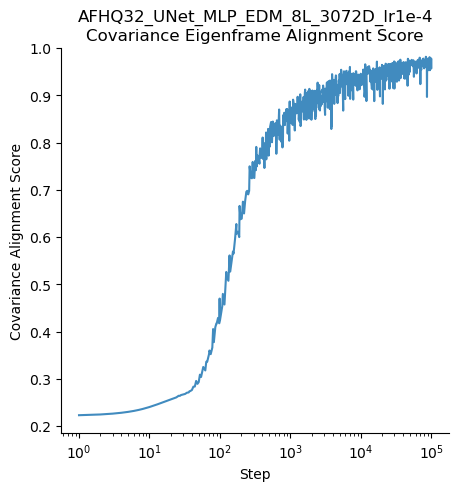

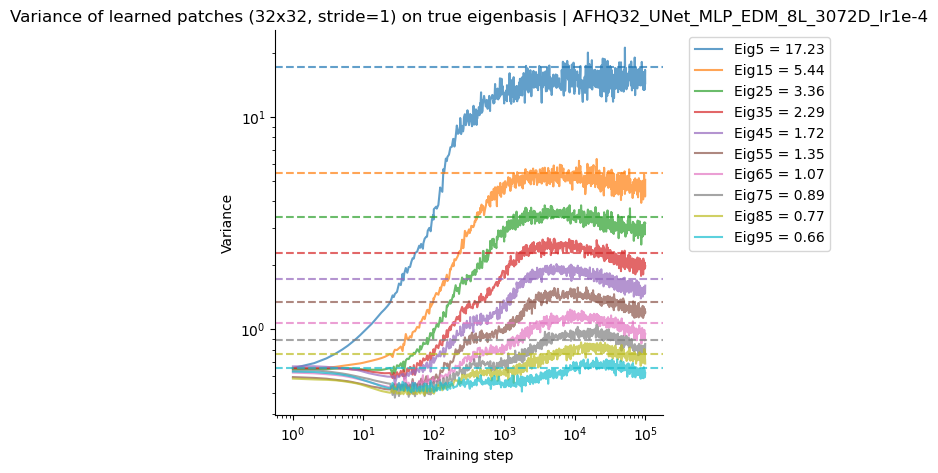

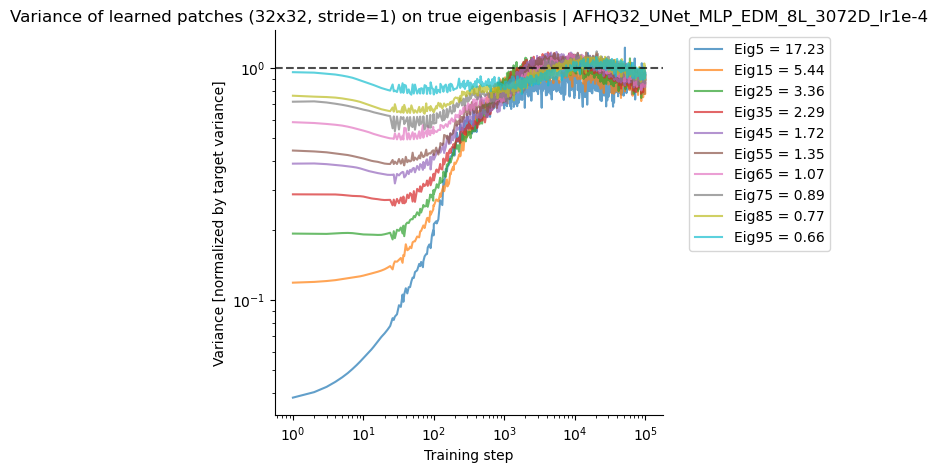

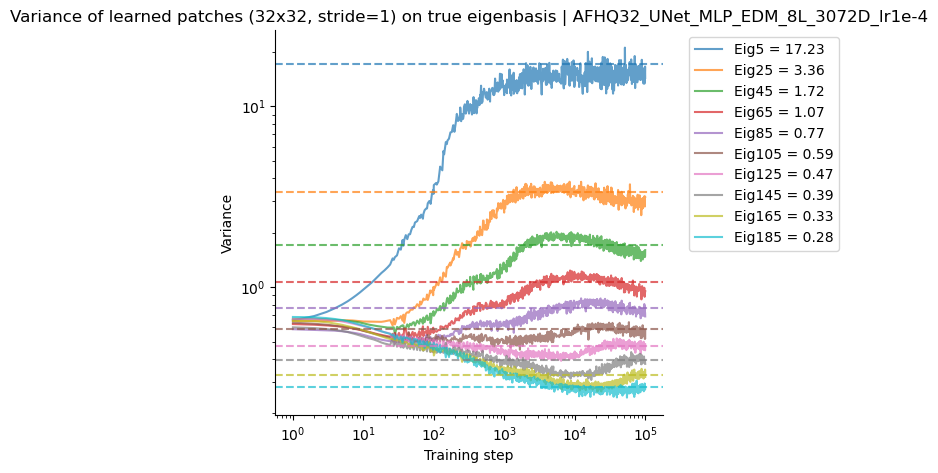

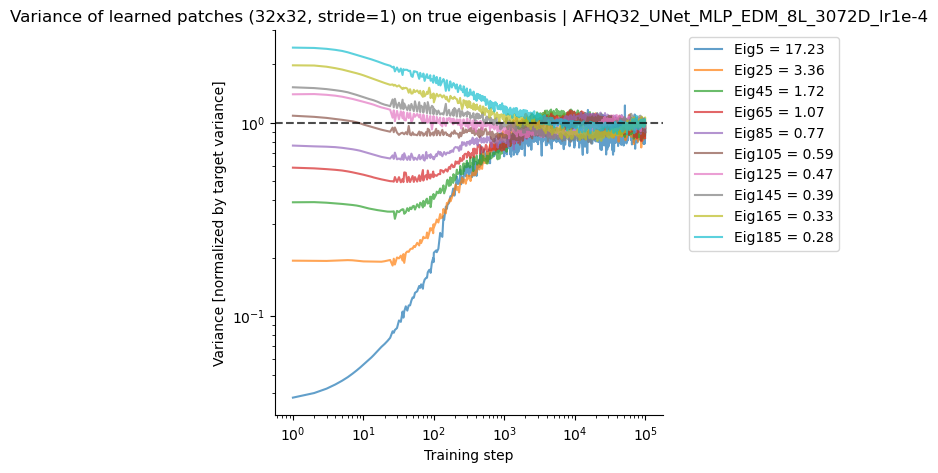

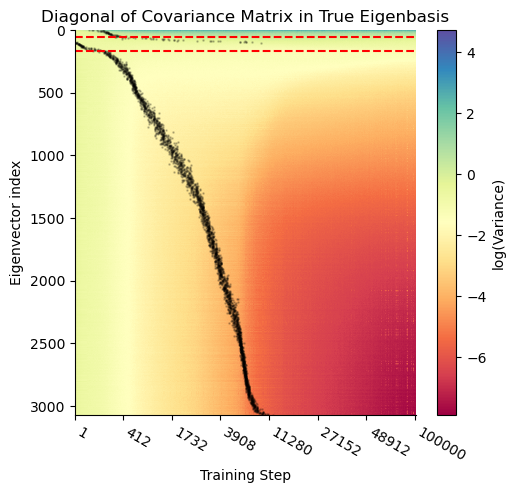

Direction: increase
Slope: -0.42, Intercept: 5.92, R-squared: 0.84 (log-log) [N=57]
Equation: $y = 374.07 x^{-0.42}$
Direction: decrease
Slope: -0.35, Intercept: 5.78, R-squared: 0.92 (log-log) [N=2904]
Equation: $y = 324.82 x^{-0.35}$


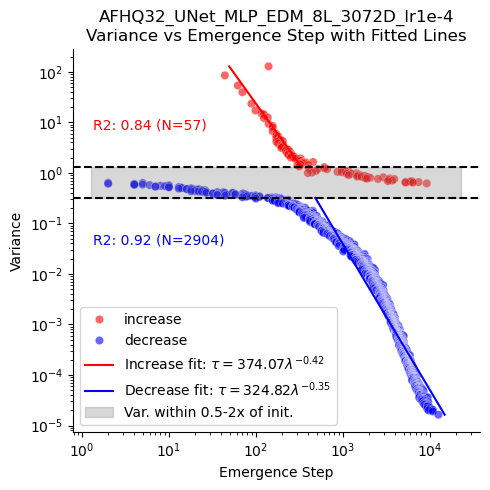

1


NameError: name 'to_imgrid' is not defined

In [8]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"
for expname, dataset_name in [("AFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "afhq-32x32"),
                            #   ("FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32"), 
                            #   ("FFHQ32_fix_words_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32-fix_words"),
                            #   ("FFHQ32_random_words_jitter_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32-random_word_jitter"),
                            #   ("CIFAR10_UNet_MLP_EDM_8L_3072D_lr1e-4", "CIFAR"),
                              ]:
    Xtsr, imgsize = load_dataset(dataset_name, normalize=True)
    savedir = join(exproot, expname)
    # figdir = join(savedir, "figures")
    figdir = f"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/MLP_export_figs_{expname}"
    os.makedirs(figdir, exist_ok=True)
    sampledir = join(savedir, "samples")
    sample_store = sweep_and_create_sample_store(sampledir)
    imgshape = (3, 32, 32)
    patch_size, patch_stride = 32, 1
    step_slice = sorted(sample_store.keys())
    img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
        process_img_mean_cov_statistics(Xtsr, sample_store, savedir, device="cuda", imgshape=imgshape, save_pkl=False)
    
    #%%
    eigen_alignment_score = []
    for i in trange(len(cov_x_sample_traj)):
        alignment_score = compute_cov_alignment(cov_x_sample_traj[i].cuda(), img_eigvec.cuda())
        eigen_alignment_score.append(alignment_score)
        
    eigen_alignment_score = torch.stack(eigen_alignment_score, dim=0)
    plt.figure(figsize=(5, 5))
    plt.plot(list(step_slice), eigen_alignment_score.cpu().numpy(), alpha=0.85)
    plt.xscale("log")
    plt.ylim(None, 1)
    plt.ylabel("Covariance Alignment Score")
    plt.xlabel("Step")
    plt.title(f"{expname}\nCovariance Eigenframe Alignment Score")
    saveallforms(figdir, f"eigenvector_alignment_score_{expname}")
    plt.show()
    #%%
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                            slice(5, 200, 20), 32, 1, figdir, expname, figsize=(5, 5))
    
    emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")
    # find the eigen index that the initial variance and final variance are similar
    var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
    eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
    eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]
    #% 
    plt.figure(figsize=(5.5, 5))
    plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
    plt.colorbar(label="log(Variance)")
    plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker=".", c="k", s=3, alpha=0.2, rasterized=True)
    plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
    plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
    plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
    plt.xlabel("Training Step")
    plt.ylabel("Eigenvector index")
    plt.gca().invert_yaxis()  # Flip the y-axis
    # annotate x-axis with step_slice
    # Only show a subset of ticks to avoid overcrowding
    tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
    saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
    plt.show()
    
    #%% 
    
    
    #%%
    emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")
    init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
    mean_init_var = init_var.mean().item()
    exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)
    analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                            exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                            title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                            alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                            scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                            ax=None,
                            )
    plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
    plt.axhline(2 * mean_init_var, color="k", linestyle="--")
    # fill the area between the two lines
    XLIM = plt.gca().get_xlim()
    plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                    color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
    print("Direction: increase",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
    fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    print("Direction: decrease",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
    fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    # annotate the R2 of the fit
    plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
    plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
    plt.legend()
    saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
    plt.show()
    
    
    #%%
    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:1]
        print(step_slice[i])
        display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))

    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
    sample_col = []
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[3:4]
        sample_col.append(sample_Xtsr)
    sample_col = torch.cat(sample_col, dim=0)
    display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))

1


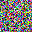

412


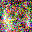

1732


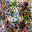

3908


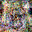

11280


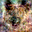

27152


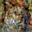

48912


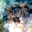

100000


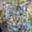

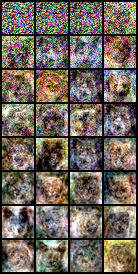

In [10]:

# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:1]
    print(step_slice[i])
    display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))

# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
sample_col = []
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[3:4]
    sample_col.append(sample_Xtsr)
sample_col = torch.cat(sample_col, dim=0)
display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))

### CIFAR10

CIFAR dataset: torch.Size([50000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/717 [00:00<?, ?it/s]

img_cov.shape: torch.Size([3072, 3072]) computed on 50000 images


  0%|          | 0/717 [00:00<?, ?it/s]

100%|██████████| 717/717 [00:14<00:00, 49.44it/s]


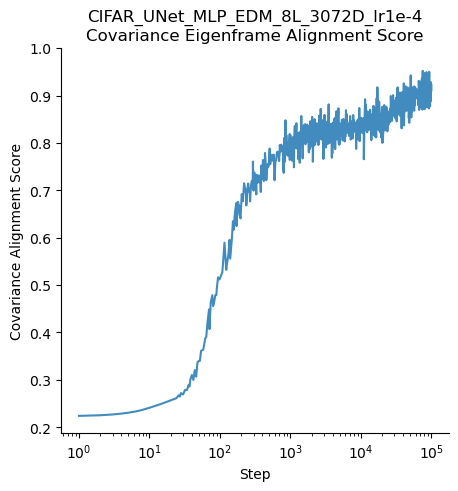

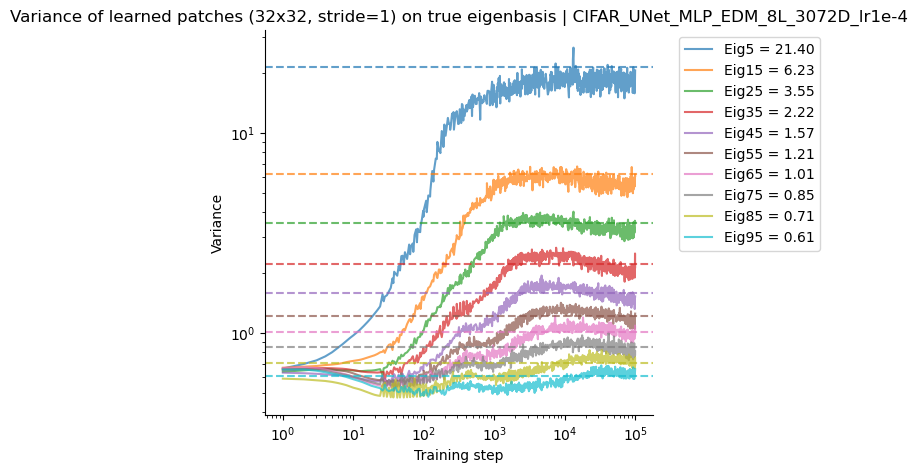

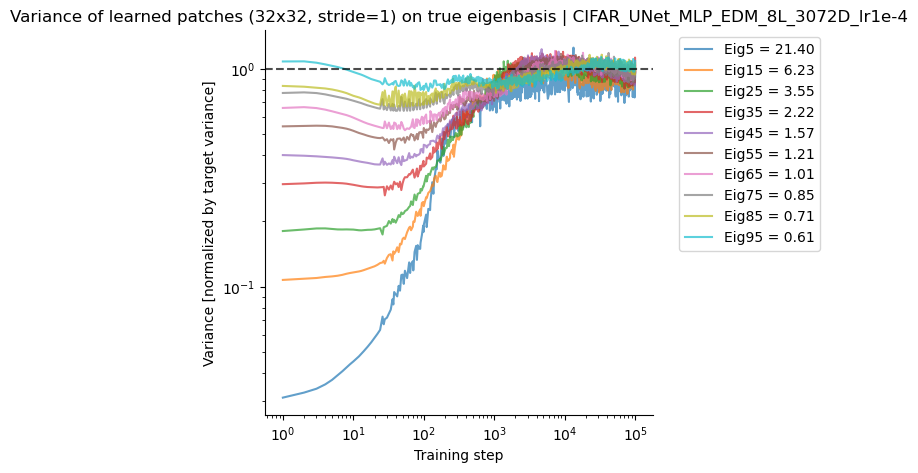

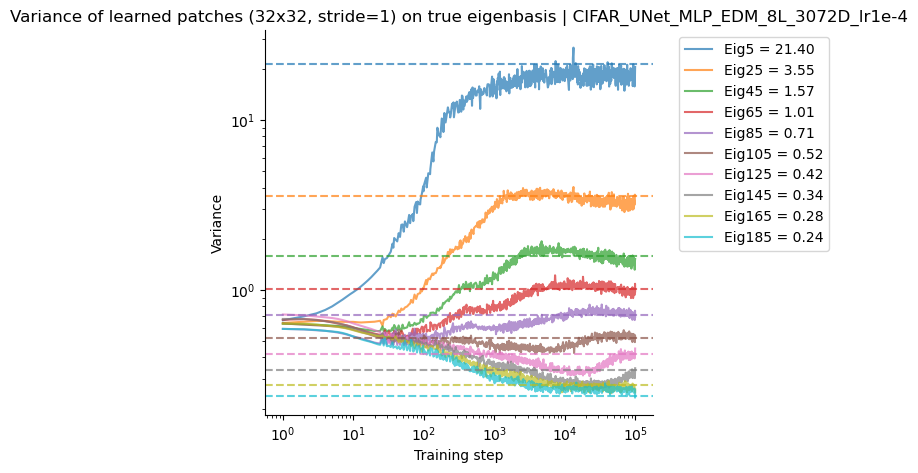

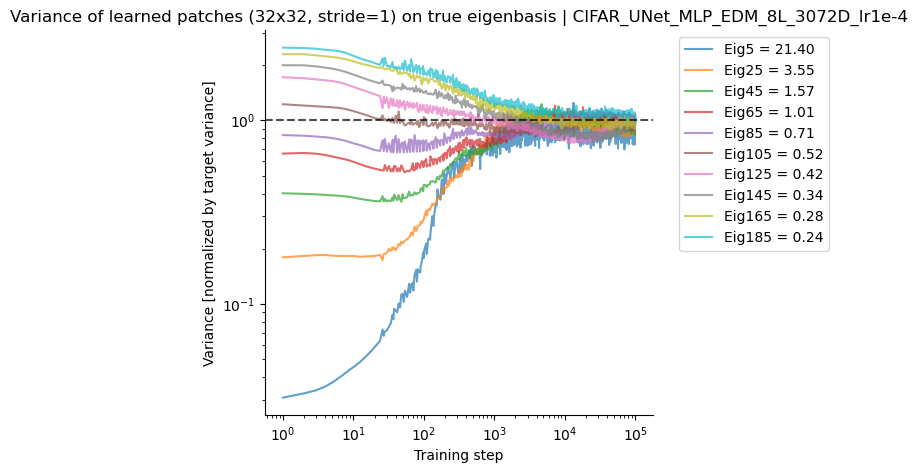

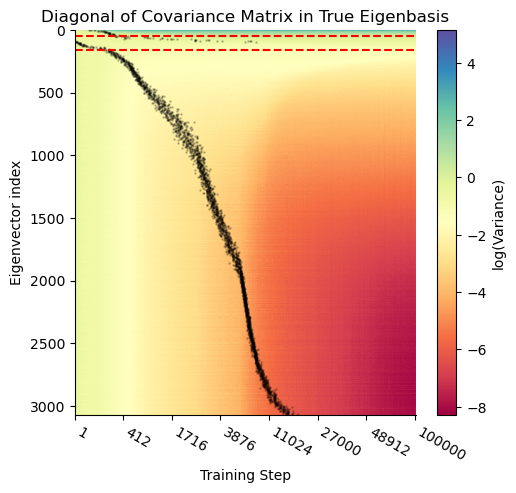

Direction: increase
Slope: -0.45, Intercept: 5.96, R-squared: 0.96 (log-log) [N=54]
Equation: $y = 387.41 x^{-0.45}$
Direction: decrease
Slope: -0.33, Intercept: 5.99, R-squared: 0.93 (log-log) [N=2922]
Equation: $y = 397.63 x^{-0.33}$


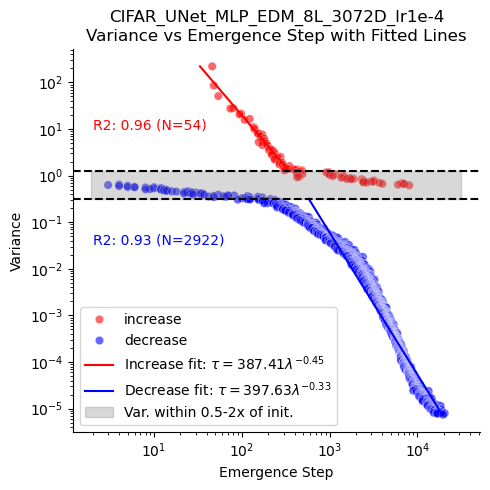

1


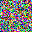

412


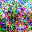

1716


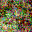

3876


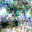

11024


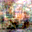

27000


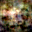

48912


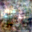

100000


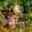

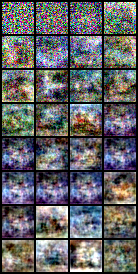

In [13]:

exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"
for expname, dataset_name in [#("AFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "afhq-32x32"),
                              ("CIFAR_UNet_MLP_EDM_8L_3072D_lr1e-4", "CIFAR"),
                            #   ("FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32"), 
                            #   ("FFHQ32_fix_words_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32-fix_words"),
                            #   ("FFHQ32_random_words_jitter_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32-random_word_jitter"),
                              ]:
    Xtsr, imgsize = load_dataset(dataset_name, normalize=True)
    savedir = join(exproot, expname)
    # figdir = join(savedir, "figures")
    figdir = f"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/MLP_export_figs_{expname}"
    os.makedirs(figdir, exist_ok=True)
    sampledir = join(savedir, "samples")
    sample_store = sweep_and_create_sample_store(sampledir)
    imgshape = (3, 32, 32)
    patch_size, patch_stride = 32, 1
    step_slice = sorted(sample_store.keys())
    img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
        process_img_mean_cov_statistics(Xtsr, sample_store, savedir, device="cuda", imgshape=imgshape, save_pkl=False)
    
    #%%
    eigen_alignment_score = []
    for i in trange(len(cov_x_sample_traj)):
        alignment_score = compute_cov_alignment(cov_x_sample_traj[i].cuda(), img_eigvec.cuda())
        eigen_alignment_score.append(alignment_score)
        
    eigen_alignment_score = torch.stack(eigen_alignment_score, dim=0)
    plt.figure(figsize=(5, 5))
    plt.plot(list(step_slice), eigen_alignment_score.cpu().numpy(), alpha=0.85)
    plt.xscale("log")
    plt.ylim(None, 1)
    plt.ylabel("Covariance Alignment Score")
    plt.xlabel("Step")
    plt.title(f"{expname}\nCovariance Eigenframe Alignment Score")
    saveallforms(figdir, f"eigenvector_alignment_score_{expname}")
    plt.show()
    #%%
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                            slice(5, 200, 20), 32, 1, figdir, expname, figsize=(5, 5))
    
    emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")
    # find the eigen index that the initial variance and final variance are similar
    var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
    eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
    eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]
    #% 
    plt.figure(figsize=(5.5, 5))
    plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
    plt.colorbar(label="log(Variance)")
    plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker=".", c="k", s=3, alpha=0.2, rasterized=True)
    plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
    plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
    plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
    plt.xlabel("Training Step")
    plt.ylabel("Eigenvector index")
    plt.gca().invert_yaxis()  # Flip the y-axis
    # annotate x-axis with step_slice
    # Only show a subset of ticks to avoid overcrowding
    tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
    saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
    plt.show()
    
    #%% 
    
    #%%
    emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")
    init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
    mean_init_var = init_var.mean().item()
    exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)
    analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                            exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                            title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                            alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                            scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                            ax=None,
                            )
    plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
    plt.axhline(2 * mean_init_var, color="k", linestyle="--")
    # fill the area between the two lines
    XLIM = plt.gca().get_xlim()
    plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                    color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
    print("Direction: increase",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
    fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    print("Direction: decrease",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
    fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    # annotate the R2 of the fit
    plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
    plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
    plt.legend()
    saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
    plt.show()
    
    
    #%%
    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:1]
        print(step_slice[i])
        display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))

    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
    sample_col = []
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[3:4]
        sample_col.append(sample_Xtsr)
    sample_col = torch.cat(sample_col, dim=0)
    display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))

1


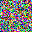

412


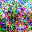

1716


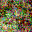

3876


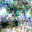

11024


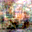

27000


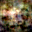

48912


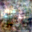

100000


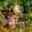

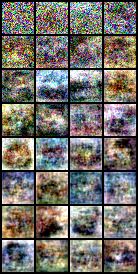

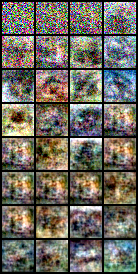

In [17]:

#%%
# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:1]
    print(step_slice[i])
    display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))

# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
sample_col = []
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[i:i+1]
    sample_col.append(sample_Xtsr)
sample_col = torch.cat(sample_col, dim=0)
display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))
# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
sample_col = []
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[2:3]
    sample_col.append(sample_Xtsr)
sample_col = torch.cat(sample_col, dim=0)
display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))

### FFHQ fixed text

In [7]:
torch.cuda.empty_cache()

ffhq-32x32-fix_words dataset: torch.Size([70000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/592 [00:00<?, ?it/s]

img_cov.shape: torch.Size([3072, 3072]) computed on 70000 images


  0%|          | 0/592 [00:00<?, ?it/s]

100%|██████████| 592/592 [00:11<00:00, 50.63it/s]


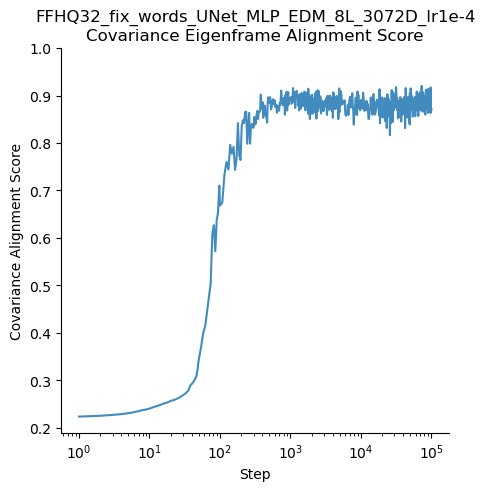

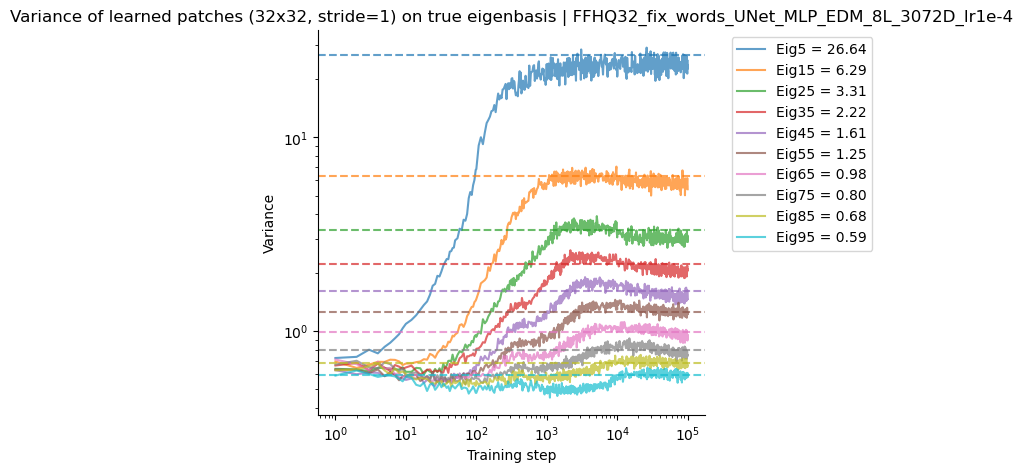

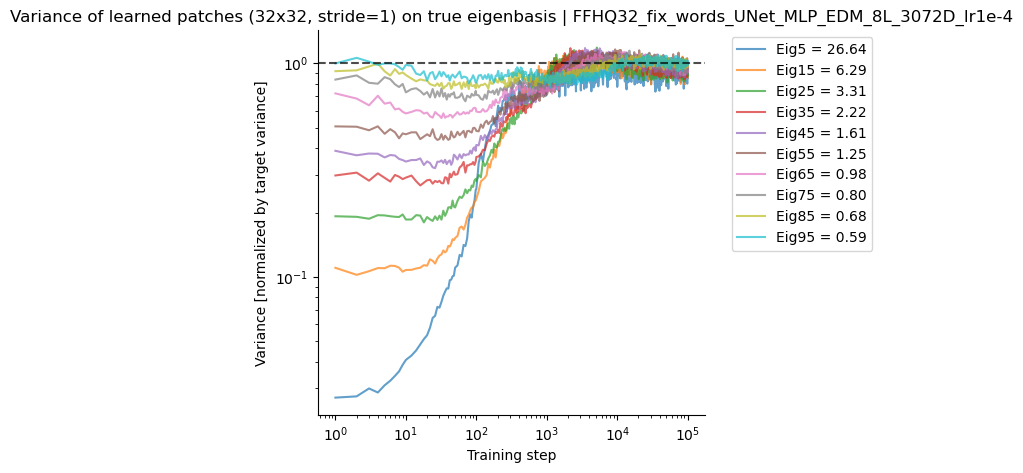

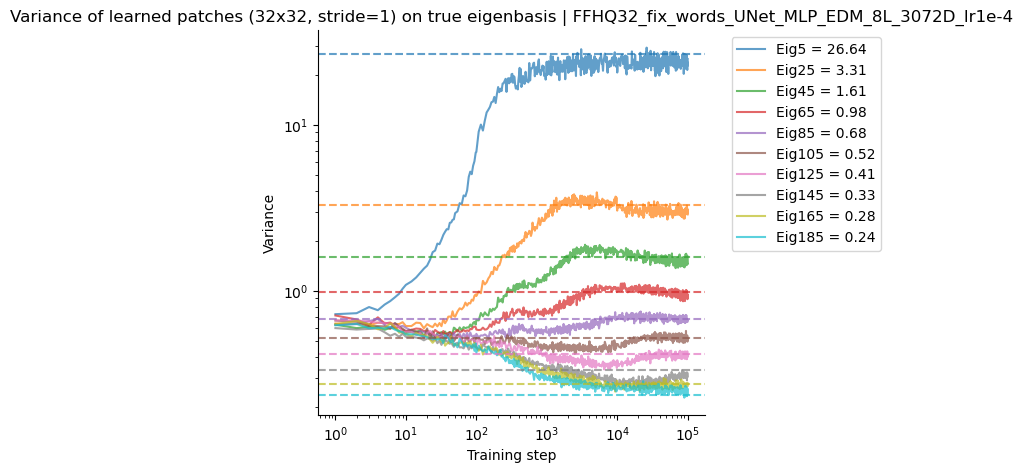

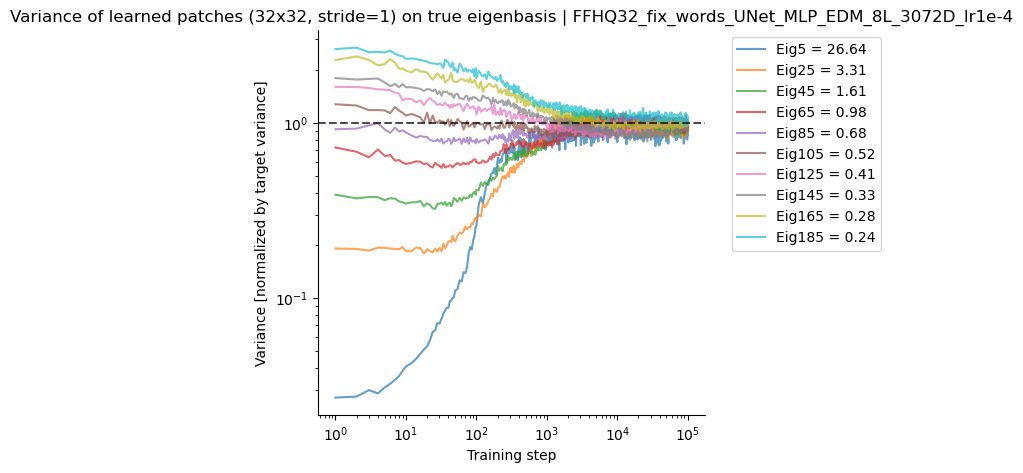

No crossing found for mode 3070
No crossing found for mode 3071


/n/home12/binxuwang/Github/DiffusionLearningCurve/core/img_patch_stats_analysis_lib.py:488: RuntimeWarning: invalid value encountered in sqrt
  threshold = np.sqrt(patch_eigval[i] * trajectory[0])


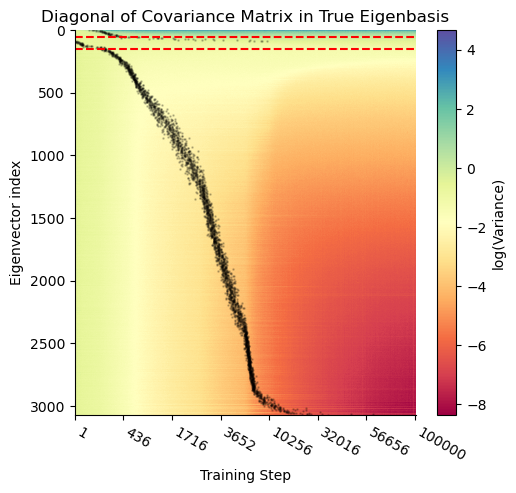

No crossing found for mode 3070
No crossing found for mode 3071
Not enough data points to fit for direction: nan


/n/home12/binxuwang/Github/DiffusionLearningCurve/core/img_patch_stats_analysis_lib.py:488: RuntimeWarning: invalid value encountered in sqrt
  threshold = np.sqrt(patch_eigval[i] * trajectory[0])


Direction: increase
Slope: -0.51, Intercept: 6.03, R-squared: 0.94 (log-log) [N=55]
Equation: $y = 414.06 x^{-0.51}$
Direction: decrease
Slope: -0.35, Intercept: 5.85, R-squared: 0.93 (log-log) [N=2920]
Equation: $y = 348.48 x^{-0.35}$


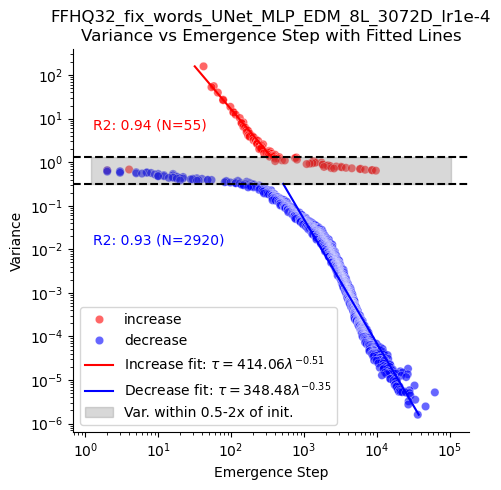

1


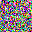

436


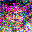

1716


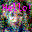

3652


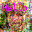

10256


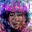

32016


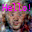

56656


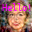

100000


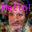

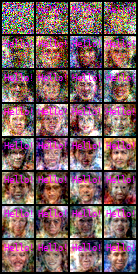

In [6]:

exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"
for expname, dataset_name in [#("AFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "afhq-32x32"),
                            #   ("CIFAR_UNet_MLP_EDM_8L_3072D_lr1e-4", "CIFAR"),
                            #   ("FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32"), 
                              ("FFHQ32_fix_words_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32-fix_words"),
                            #   ("FFHQ32_random_words_jitter_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32-random_word_jitter"),
                              ]:
    Xtsr, imgsize = load_dataset(dataset_name, normalize=True)
    savedir = join(exproot, expname)
    # figdir = join(savedir, "figures")
    figdir = f"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/MLP_export_figs_{expname}"
    os.makedirs(figdir, exist_ok=True)
    sampledir = join(savedir, "samples")
    sample_store = sweep_and_create_sample_store(sampledir)
    imgshape = (3, 32, 32)
    patch_size, patch_stride = 32, 1
    step_slice = sorted(sample_store.keys())
    img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
        process_img_mean_cov_statistics(Xtsr, sample_store, savedir, device="cuda", imgshape=imgshape, save_pkl=False)
    
    #%%
    eigen_alignment_score = []
    for i in trange(len(cov_x_sample_traj)):
        alignment_score = compute_cov_alignment(cov_x_sample_traj[i].cuda(), img_eigvec.cuda())
        eigen_alignment_score.append(alignment_score)
        
    eigen_alignment_score = torch.stack(eigen_alignment_score, dim=0)
    plt.figure(figsize=(5, 5))
    plt.plot(list(step_slice), eigen_alignment_score.cpu().numpy(), alpha=0.85)
    plt.xscale("log")
    plt.ylim(None, 1)
    plt.ylabel("Covariance Alignment Score")
    plt.xlabel("Step")
    plt.title(f"{expname}\nCovariance Eigenframe Alignment Score")
    saveallforms(figdir, f"eigenvector_alignment_score_{expname}")
    plt.show()
    #%%
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                            slice(5, 200, 20), 32, 1, figdir, expname, figsize=(5, 5))
    
    emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")
    # find the eigen index that the initial variance and final variance are similar
    var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
    eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
    eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]
    #% 
    plt.figure(figsize=(5.5, 5))
    plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
    plt.colorbar(label="log(Variance)")
    plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker=".", c="k", s=3, alpha=0.2, rasterized=True)
    plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
    plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
    plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
    plt.xlabel("Training Step")
    plt.ylabel("Eigenvector index")
    plt.gca().invert_yaxis()  # Flip the y-axis
    # annotate x-axis with step_slice
    # Only show a subset of ticks to avoid overcrowding
    tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
    saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
    plt.show()
    
    #%% 
    
    #%%
    emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")
    init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
    mean_init_var = init_var.mean().item()
    exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)
    analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                            exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                            title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                            alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                            scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                            ax=None,
                            )
    plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
    plt.axhline(2 * mean_init_var, color="k", linestyle="--")
    # fill the area between the two lines
    XLIM = plt.gca().get_xlim()
    plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                    color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
    print("Direction: increase",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
    fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    print("Direction: decrease",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
    fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    # annotate the R2 of the fit
    plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
    plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
    plt.legend()
    saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
    plt.show()
    
    
    #%%
    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:1]
        print(step_slice[i])
        display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))

    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
    sample_col = []
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[3:4]
        sample_col.append(sample_Xtsr)
    sample_col = torch.cat(sample_col, dim=0)
    display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))

In [10]:
del img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj,sample_store
torch.cuda.empty_cache()

### FFHQ32 Random Jitter

ffhq-32x32-random_word_jitter dataset: torch.Size([70000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/592 [00:00<?, ?it/s]

img_cov.shape: torch.Size([3072, 3072]) computed on 70000 images


  0%|          | 0/592 [00:00<?, ?it/s]

100%|██████████| 592/592 [00:12<00:00, 49.03it/s]


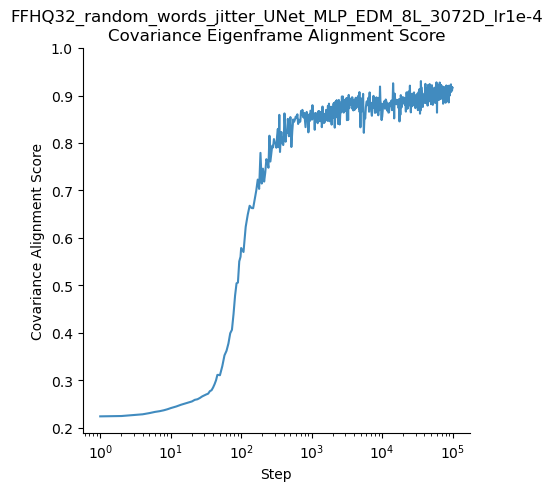

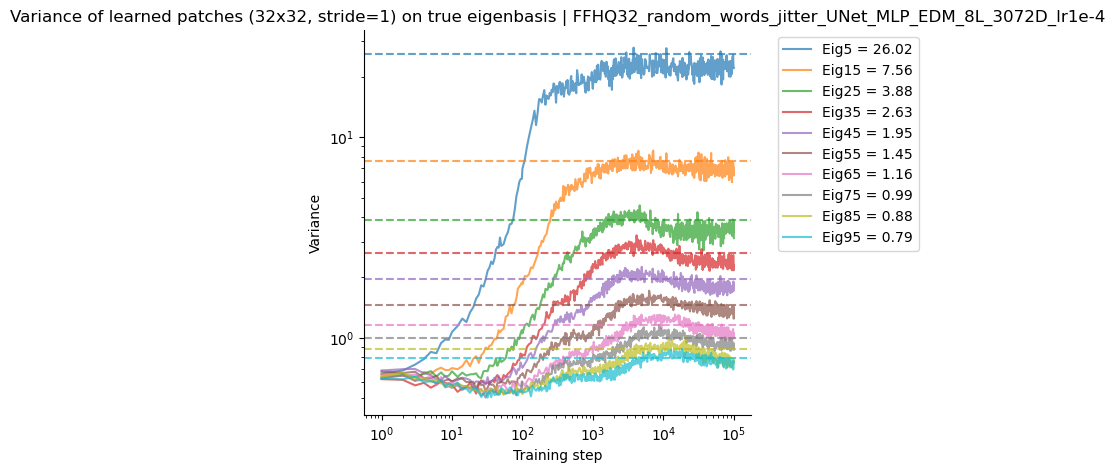

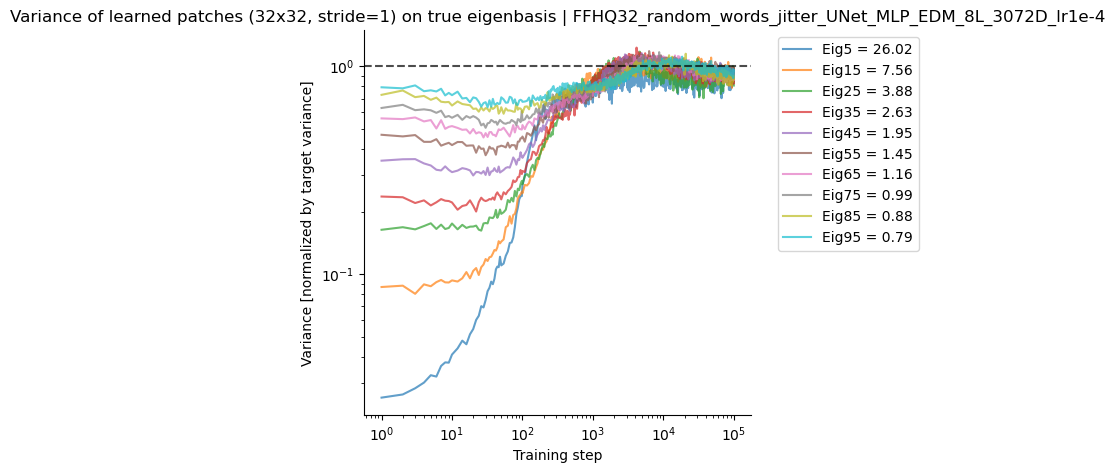

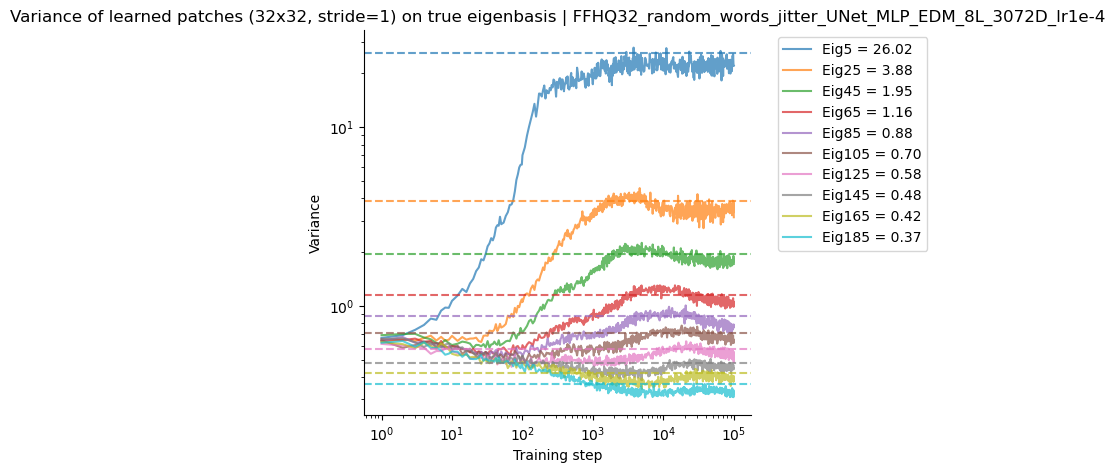

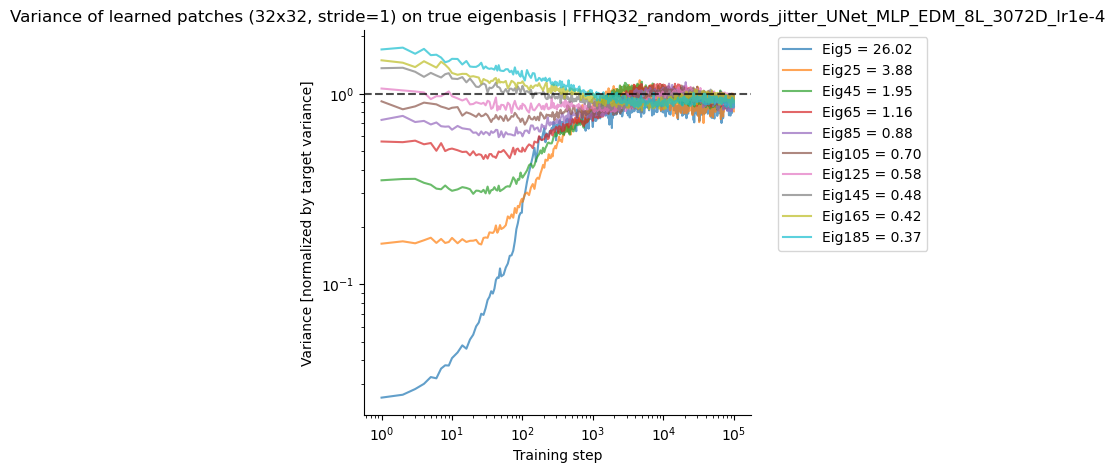

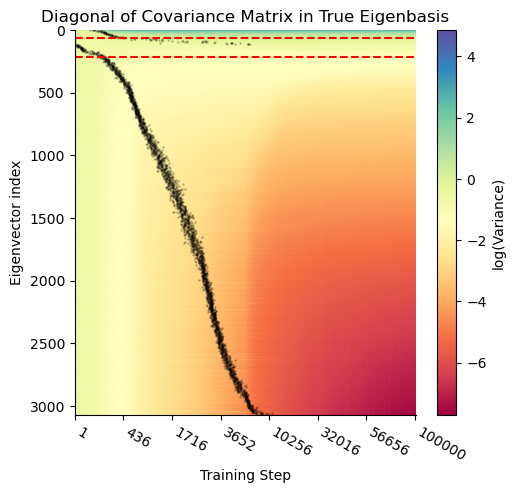

Direction: increase
Slope: -0.49, Intercept: 5.97, R-squared: 0.97 (log-log) [N=61]
Equation: $y = 392.10 x^{-0.49}$
Direction: decrease
Slope: -0.37, Intercept: 5.68, R-squared: 0.90 (log-log) [N=2862]
Equation: $y = 291.51 x^{-0.37}$


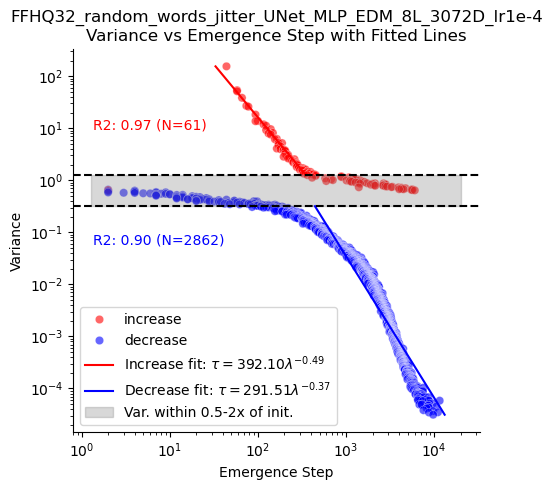

1


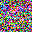

436


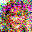

1716


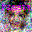

3652


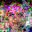

10256


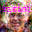

32016


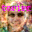

56656


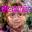

100000


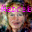

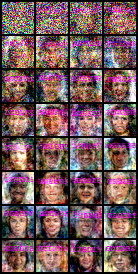

In [9]:

exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"
for expname, dataset_name in [#("AFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "afhq-32x32"),
                            #   ("CIFAR_UNet_MLP_EDM_8L_3072D_lr1e-4", "CIFAR"),
                            #   ("FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32"), 
                            #   ("FFHQ32_fix_words_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32-fix_words"),
                              ("FFHQ32_random_words_jitter_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32-random_word_jitter"),
                              ]:
    Xtsr, imgsize = load_dataset(dataset_name, normalize=True)
    savedir = join(exproot, expname)
    # figdir = join(savedir, "figures")
    figdir = f"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/MLP_export_figs_{expname}"
    os.makedirs(figdir, exist_ok=True)
    sampledir = join(savedir, "samples")
    sample_store = sweep_and_create_sample_store(sampledir)
    imgshape = (3, 32, 32)
    patch_size, patch_stride = 32, 1
    step_slice = sorted(sample_store.keys())
    img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
        process_img_mean_cov_statistics(Xtsr, sample_store, savedir, device="cuda", imgshape=imgshape, save_pkl=False)
    
    #%%
    eigen_alignment_score = []
    for i in trange(len(cov_x_sample_traj)):
        alignment_score = compute_cov_alignment(cov_x_sample_traj[i].cuda(), img_eigvec.cuda())
        eigen_alignment_score.append(alignment_score)
        
    eigen_alignment_score = torch.stack(eigen_alignment_score, dim=0)
    plt.figure(figsize=(5, 5))
    plt.plot(list(step_slice), eigen_alignment_score.cpu().numpy(), alpha=0.85)
    plt.xscale("log")
    plt.ylim(None, 1)
    plt.ylabel("Covariance Alignment Score")
    plt.xlabel("Step")
    plt.title(f"{expname}\nCovariance Eigenframe Alignment Score")
    saveallforms(figdir, f"eigenvector_alignment_score_{expname}")
    plt.show()
    #%%
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                            slice(5, 200, 20), 32, 1, figdir, expname, figsize=(5, 5))
    
    emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")
    # find the eigen index that the initial variance and final variance are similar
    var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
    eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
    eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]
    #% 
    plt.figure(figsize=(5.5, 5))
    plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
    plt.colorbar(label="log(Variance)")
    plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker=".", c="k", s=3, alpha=0.2, rasterized=True)
    plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
    plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
    plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
    plt.xlabel("Training Step")
    plt.ylabel("Eigenvector index")
    plt.gca().invert_yaxis()  # Flip the y-axis
    # annotate x-axis with step_slice
    # Only show a subset of ticks to avoid overcrowding
    tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
    saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
    plt.show()
    
    #%% 
    
    #%%
    emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")
    init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
    mean_init_var = init_var.mean().item()
    exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)
    analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                            exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                            title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                            alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                            scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                            ax=None,
                            )
    plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
    plt.axhline(2 * mean_init_var, color="k", linestyle="--")
    # fill the area between the two lines
    XLIM = plt.gca().get_xlim()
    plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                    color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
    print("Direction: increase",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
    fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    print("Direction: decrease",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
    fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    # annotate the R2 of the fit
    plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
    plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
    plt.legend()
    saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
    plt.show()
    
    
    #%%
    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:1]
        print(step_slice[i])
        display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))

    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
    sample_col = []
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[3:4]
        sample_col.append(sample_Xtsr)
    sample_col = torch.cat(sample_col, dim=0)
    display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))

### MNIST

In [14]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST* -d

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_MLP_EDM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_MLP_EDM_width1024_small_lr_long_train
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_1block_noattn
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_1block_wide128_noattn
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_2blocks_noattn
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_UNet_CNN_EDM_4blocks_noattn
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Proje

In [17]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/MNIST_MLP_EDM_width1024_small_lr_long_train/

figures
loss_store.pkl
model_final.pth
sample_pnts_cov_true_eigenbasis_diag_traj.pkl
samples
sample_store.pkl
synopsis_eigenmode_emergence_harmonic_mean_vs_variance.csv
synopsis_eigenmode_emergence_harmonic_mean_vs_variance.pdf
synopsis_eigenmode_emergence_harmonic_mean_vs_variance.png
train_data_cov_info.pkl


In [23]:
sample_store[1][0].shape

torch.Size([10000, 784])

In [ ]:

exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"
for expname, dataset_name in [#("AFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "afhq-32x32"),
                            #   ("CIFAR_UNet_MLP_EDM_8L_3072D_lr1e-4", "CIFAR"),
                            #   ("FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32"), 
                            #   ("FFHQ32_fix_words_UNet_MLP_EDM_8L_3072D_lr1e-4", "ffhq-32x32-fix_words"),
                              ("MNIST_MLP_EDM_width1024_small_lr_long_train", "MNIST28"),
                              ]:
    Xtsr, imgsize = load_dataset(dataset_name, normalize=True)
    savedir = join(exproot, expname)
    # figdir = join(savedir, "figures")
    figdir = f"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/MLP_export_figs_{expname}"
    os.makedirs(figdir, exist_ok=True)
    sampledir = join(savedir, "samples")
    # sample_store = sweep_and_create_sample_store(sampledir)
    # sample_store.pkl
    sample_store = pkl.load(open(join(savedir, "sample_store.pkl"), "rb"))
    imgshape = (1, 28, 28)
    patch_size, patch_stride = 28, 1
    step_slice = sorted(sample_store.keys())
    img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
        process_img_mean_cov_statistics(Xtsr, sample_store, savedir, device="cuda", imgshape=imgshape, save_pkl=False)
    
    #%%
    eigen_alignment_score = []
    for i in trange(len(cov_x_sample_traj)):
        alignment_score = compute_cov_alignment(cov_x_sample_traj[i].cuda(), img_eigvec.cuda())
        eigen_alignment_score.append(alignment_score)
        
    eigen_alignment_score = torch.stack(eigen_alignment_score, dim=0)
    plt.figure(figsize=(5, 5))
    plt.plot(list(step_slice), eigen_alignment_score.cpu().numpy(), alpha=0.85)
    plt.xscale("log")
    plt.ylim(None, 1)
    plt.ylabel("Covariance Alignment Score")
    plt.xlabel("Step")
    plt.title(f"{expname}\nCovariance Eigenframe Alignment Score")
    saveallforms(figdir, f"eigenvector_alignment_score_{expname}")
    plt.show()
    #%%
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))
    plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                            slice(5, 200, 20), 32, 1, figdir, expname, figsize=(5, 5))
    
    emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")
    # find the eigen index that the initial variance and final variance are similar
    var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
    eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
    eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]
    #% 
    plt.figure(figsize=(5.5, 5))
    plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
    plt.colorbar(label="log(Variance)")
    plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker=".", c="k", s=3, alpha=0.2, rasterized=True)
    plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
    plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
    plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
    plt.xlabel("Training Step")
    plt.ylabel("Eigenvector index")
    plt.gca().invert_yaxis()  # Flip the y-axis
    # annotate x-axis with step_slice
    # Only show a subset of ticks to avoid overcrowding
    tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
    saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
    plt.show()
    
    #%% 
    
    #%%
    emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")
    init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
    mean_init_var = init_var.mean().item()
    exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)
    analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                            exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                            title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                            alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                            scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                            ax=None,
                            )
    plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
    plt.axhline(2 * mean_init_var, color="k", linestyle="--")
    # fill the area between the two lines
    XLIM = plt.gca().get_xlim()
    plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                    color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
    print("Direction: increase",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
    fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    print("Direction: decrease",)
    df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
    fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
    # annotate the R2 of the fit
    plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
    plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
    plt.legend()
    saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
    plt.show()
    
    
    #%%
    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:1]
        print(step_slice[i])
        display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))

    # equidistant sample from step_slice
    sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
    sample_col = []
    for i in sample_step_idx:
        sample_Xmat = sample_store[step_slice[i]]
        sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[3:4]
        sample_col.append(sample_Xtsr)
    sample_col = torch.cat(sample_col, dim=0)
    display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))

MNIST28 dataset: torch.Size([60000, 1, 28, 28])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


### FFHQ32 UNET MLP

In [2]:
#%% Load in the Sample Stores FFHQ MLP 
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/"
Xtsr, imgsize = load_dataset("ffhq-32x32", normalize=True)
expname = "FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4"
savedir = join(exproot, expname)
figdir = join(savedir, "figures")
os.makedirs(figdir, exist_ok=True)
sampledir = join(savedir, "samples")
sample_store = sweep_and_create_sample_store(sampledir)
#%%
imgshape = (3, 32, 32)
patch_size, patch_stride = 32, 1
step_slice = sorted(sample_store.keys())
img_mean, img_cov, img_eigval, img_eigvec, mean_x_sample_traj, cov_x_sample_traj, diag_cov_x_sample_true_eigenbasis_traj = \
     process_img_mean_cov_statistics(Xtsr, sample_store, savedir, device="cuda", imgshape=imgshape, save_pkl=False)

ffhq-32x32 dataset: torch.Size([70000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


  0%|          | 0/719 [00:00<?, ?it/s]

img_cov.shape: torch.Size([3072, 3072]) computed on 70000 images


  0%|          | 0/719 [00:00<?, ?it/s]

### Measure covariance alignment on eigenframe

In [177]:
eigen_alignment_score = []
for i in trange(len(cov_x_sample_traj)):
    alignment_score = compute_cov_alignment(cov_x_sample_traj[i].cuda(), img_eigvec.cuda())
    eigen_alignment_score.append(alignment_score)
    
eigen_alignment_score = torch.stack(eigen_alignment_score, dim=0)
eigen_alignment_score.shape


  0%|          | 0/719 [00:00<?, ?it/s]

100%|██████████| 719/719 [00:07<00:00, 100.68it/s]


torch.Size([719])

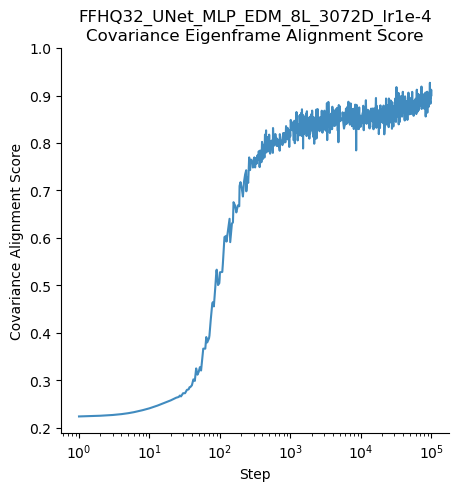

In [179]:
plt.figure(figsize=(5, 5))
plt.plot(list(step_slice), eigen_alignment_score.cpu().numpy(), alpha=0.85)
plt.xscale("log")
plt.ylim(None, 1)
plt.ylabel("Covariance Alignment Score")
plt.xlabel("Step")
plt.title(f"{expname}\nCovariance Eigenframe Alignment Score")
saveallforms(figdir, f"eigenvector_alignment_score_{expname}")
plt.show()
# plt.savefig(join(figdir, "eigenvector_alignment_score_ffhq_mlp.png"), dpi=300)

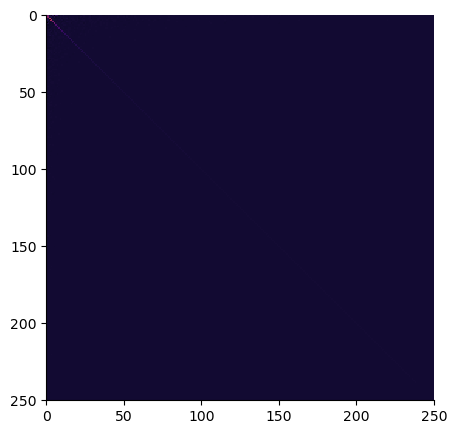

In [170]:
# plot the covariance matrix in the eigenbasis
plt.figure(figsize=(5, 5))
# cov_x_sample_traj[i].cuda(), img_eigvec.cuda()
cov_rot = img_eigvec.cuda().T @ cov_x_sample_traj[-1].cuda() @ img_eigvec.cuda()
plt.pcolor(cov_rot.cpu().numpy()[:250,:250], cmap="inferno", rasterized=True)
# reverse the y-axis
plt.gca().invert_yaxis()
# plt.colorbar(label="Variance")
# plt.title("Covariance Matrix in True Eigenbasis")
# plt.xlabel("Training Step")
# plt.ylabel("Eigenvector index")
plt.show()

### Plot the variance heatmap

In [180]:
from core.trajectory_convergence_lib import smooth_and_find_threshold_crossing, compute_crossing_points
from core.img_patch_stats_analysis_lib import plot_variance_trajectories

In [112]:
figdir = f"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/MLP_export_figs"

In [66]:
emer_time_df = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), range(len(step_slice)), smooth_sigma=1, threshold_type="geometric_mean")

In [73]:
# find the eigen index that the initial variance and final variance are similar
var_ratio = diag_cov_x_sample_true_eigenbasis_traj[0,:] / img_eigval.cpu()
eig_idx_tooclose = (var_ratio > 0.5) & (var_ratio < 2)
eig_idx_tooclose_vec = eig_idx_tooclose.nonzero()[:,0]

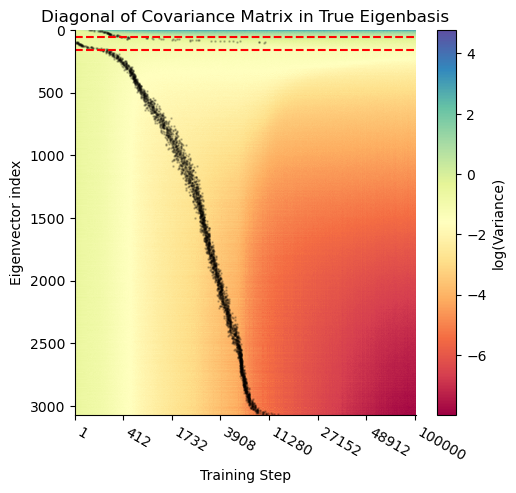

In [ ]:
plt.figure(figsize=(5.5, 5))
plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral")
plt.colorbar(label="log(Variance)")
plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker=".", c="k", s=3, alpha=0.2)
plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
plt.xlabel("Training Step")
plt.ylabel("Eigenvector index")
plt.gca().invert_yaxis()  # Flip the y-axis
# annotate x-axis with step_slice
# Only show a subset of ticks to avoid overcrowding
tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
# saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}") # this will be huge! 
plt.show()

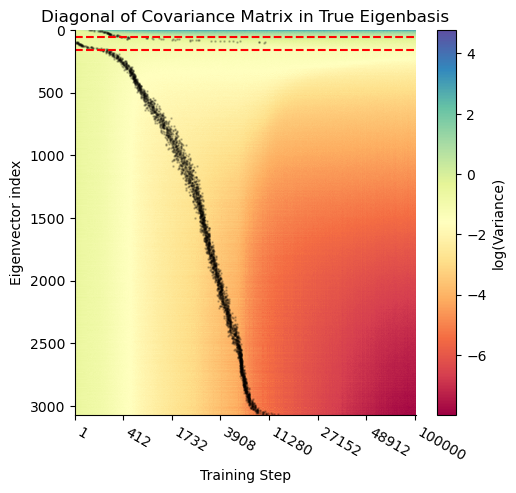

In [124]:
plt.figure(figsize=(5.5, 5))
plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
plt.colorbar(label="log(Variance)")
plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker=".", c="k", s=3, alpha=0.2, rasterized=True)
plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
plt.xlabel("Training Step")
plt.ylabel("Eigenvector index")
plt.gca().invert_yaxis()  # Flip the y-axis
# annotate x-axis with step_slice
# Only show a subset of ticks to avoid overcrowding
tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
plt.show()

### Plot the classic variance trajectory

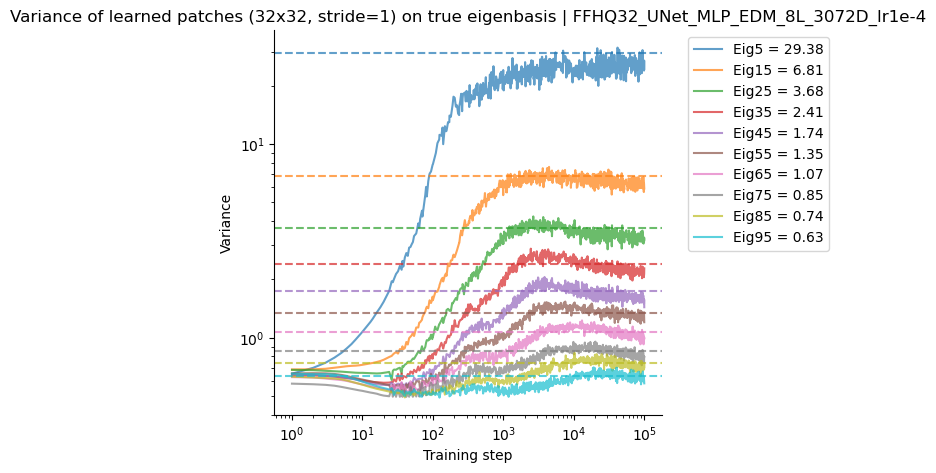

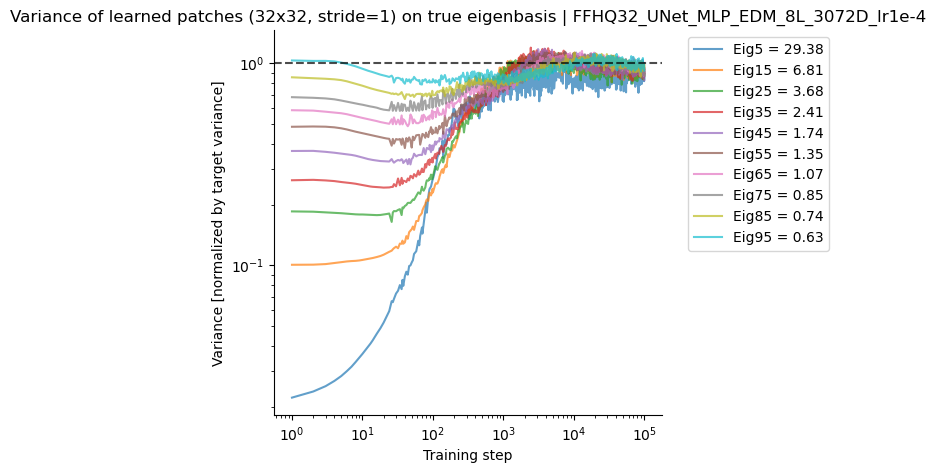

In [184]:
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 100, 10), 32, 1, figdir, expname, figsize=(5, 5))

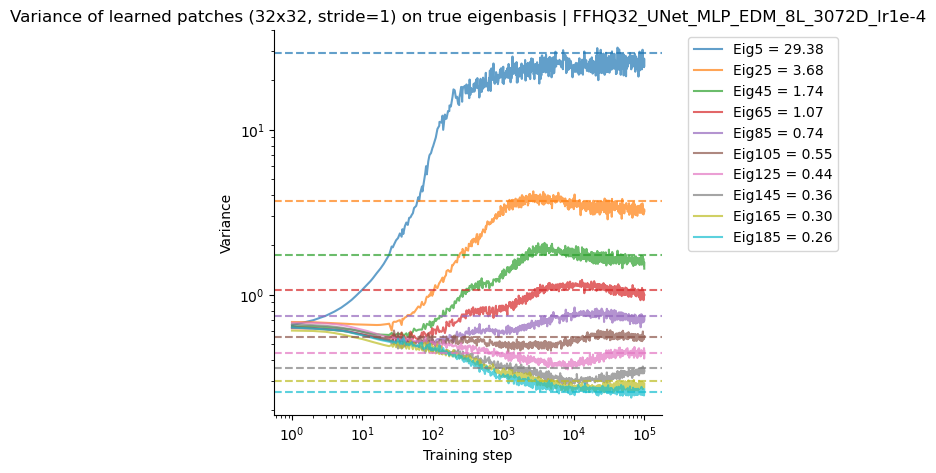

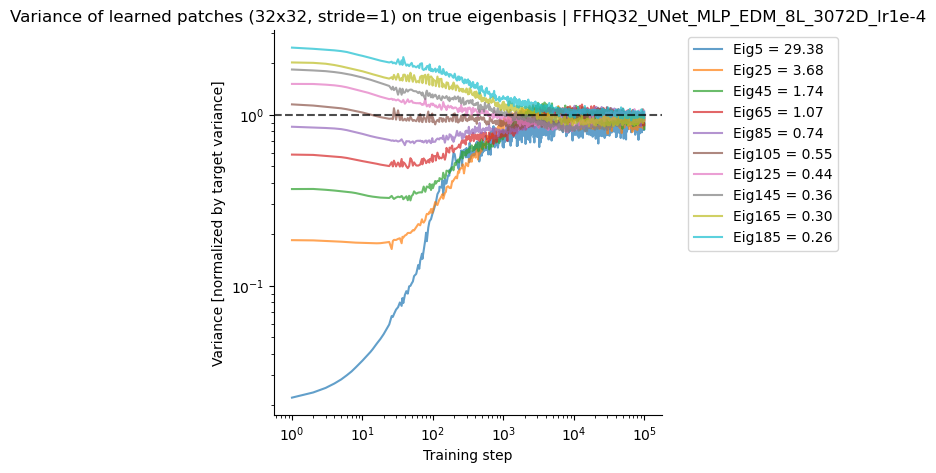

In [185]:
plot_variance_trajectories(step_slice, diag_cov_x_sample_true_eigenbasis_traj.cpu(), img_eigval.cpu(), 
                           slice(5, 200, 20), 32, 1, figdir, expname, figsize=(5, 5))

In [ ]:
plt.figure(figsize=(5.5, 5))
plt.pcolor(diag_cov_x_sample_true_eigenbasis_traj.log().cpu().numpy().T, cmap="Spectral", rasterized=True)
plt.plot(step_slice, img_eigval.cpu().numpy(), color="k", linestyle="--", label="Eigenvalue")
plt.colorbar(label="log(Variance)")
# plt.scatter(emer_time_df["emergence_step"].to_numpy(), emer_time_df.index.to_numpy(), marker=".", c="k", s=3, alpha=0.2, rasterized=True)
plt.axhline(eig_idx_tooclose_vec[0], color="r", linestyle="--")
plt.axhline(eig_idx_tooclose_vec[-1], color="r", linestyle="--")
plt.title("Diagonal of Covariance Matrix in True Eigenbasis")
plt.xlabel("Training Step")
plt.ylabel("Eigenvector index")
plt.gca().invert_yaxis()  # Flip the y-axis
# annotate x-axis with step_slice
# Only show a subset of ticks to avoid overcrowding
tick_indices = np.linspace(0, len(step_slice)-1, 8, dtype=int)
plt.xticks(tick_indices, [step_slice[i] for i in tick_indices], rotation=-30, ha="left")
# saveallforms(figdir, f"eigenframe_variance_heatmap_{expname}_rasterized", dpi=300)
plt.show()

### Plot the fit line

In [ ]:
init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
mean_init_var = init_var.mean().item()
exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)

In [ ]:
exclude_mask.sum()

101

In [145]:
print("Direction: increase",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
print("Direction: decrease",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)

Direction: increase
Slope: -0.48, Intercept: 5.99, R-squared: 0.97 (log-log) [N=57]
Equation: $y = 398.37 x^{-0.48}$
Direction: decrease
Slope: -0.35, Intercept: 5.82, R-squared: 0.92 (log-log) [N=2914]
Equation: $y = 338.02 x^{-0.35}$


{'a': 338.01996,
 'b': -0.35398474,
 'intercept': 5.823105,
 'slope': -0.35398474,
 'r_squared': 0.9202378618924506}

Direction: increase
Slope: -0.48, Intercept: 5.99, R-squared: 0.97 (log-log) [N=57]
Equation: $y = 398.37 x^{-0.48}$
Direction: decrease
Slope: -0.35, Intercept: 5.82, R-squared: 0.92 (log-log) [N=2914]
Equation: $y = 338.02 x^{-0.35}$


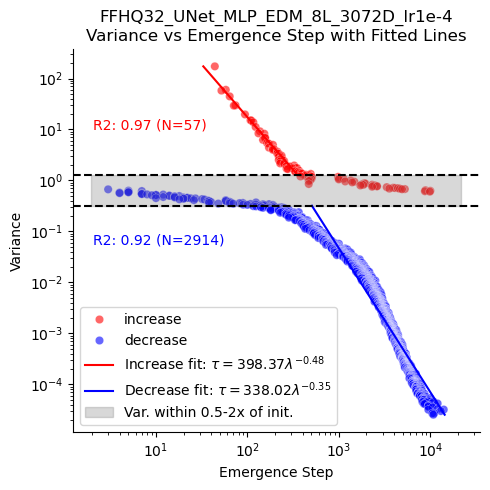

In [190]:
emer_time_df_step = compute_crossing_points(img_eigval.cpu(), diag_cov_x_sample_true_eigenbasis_traj.cpu(), step_slice, smooth_sigma=1, threshold_type="geometric_mean")

init_var = diag_cov_x_sample_true_eigenbasis_traj[0,:]
mean_init_var = init_var.mean().item()
exclude_mask = (emer_time_df_step.Variance / mean_init_var > 0.5) & (emer_time_df_step.Variance / mean_init_var < 2)

analyze_and_plot_variance(emer_time_df_step, x_col="emergence_step", y_col="Variance", hue_col="Direction", log_x=True, log_y=True, figsize=(5, 5), 
                          exclude_mask=exclude_mask, reverse_equation=True, fit_label_format='{direction} fit: $\\tau = {a:.2f} \lambda^{{{b:.2f}}}$', 
                          title=f'{expname}\nVariance vs Emergence Step with Fitted Lines', xlabel='Emergence Step', ylabel='Variance', 
                          alpha=0.6, annotate=False, annotate_offset=(0, 0), fit_line_kwargs=None, 
                          scatter_kwargs={"rasterized": True, "linewidth": 0.3}, 
                          ax=None,
                          )
plt.axhline(0.5 * mean_init_var, color="k", linestyle="--")
plt.axhline(2 * mean_init_var, color="k", linestyle="--")
# fill the area between the two lines
XLIM = plt.gca().get_xlim()
plt.fill_betweenx([0.5 * mean_init_var, 2 * mean_init_var], [XLIM[0], XLIM[0]], [XLIM[1], XLIM[1]], 
                  color="gray", alpha=0.3, label="Var. within 0.5-2x of init.")
print("Direction: increase",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'increase'")
fit_dict_increase = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
print("Direction: decrease",)
df_split = emer_time_df_step[~exclude_mask].query("Direction == 'decrease'")
fit_dict_decrease = fit_regression_log_scale(df_split.Variance, df_split.emergence_step)
# annotate the R2 of the fit
plt.text(0.05, 0.8, f"R2: {fit_dict_increase['r_squared']:.2f} (N={fit_dict_increase['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="r")
plt.text(0.05, 0.5, f"R2: {fit_dict_decrease['r_squared']:.2f} (N={fit_dict_decrease['N']})", transform=plt.gca().transAxes, ha="left", va="center", color="blue")
plt.legend()
saveallforms(figdir, f"convergence_time_vs_variance_scaling_{expname}_rasterized", dpi=300)
plt.show()

### Draw samples from the data

1


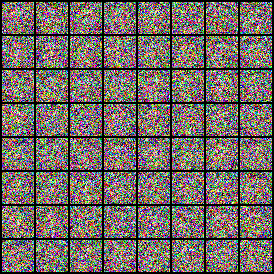

412


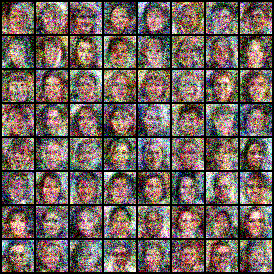

1732


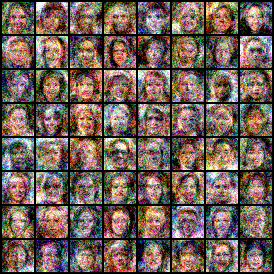

3908


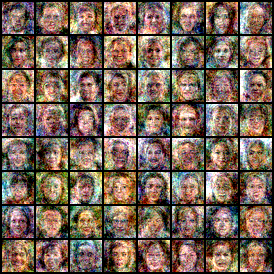

11280


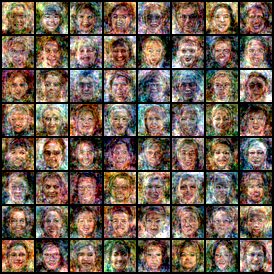

27152


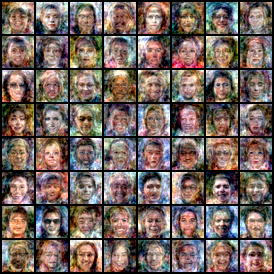

48912


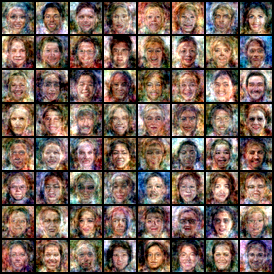

100000


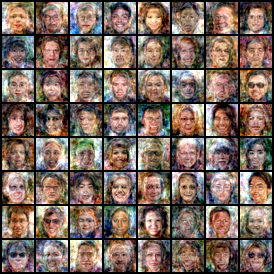

In [206]:
# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:64]
    print(step_slice[i])
    display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))


1


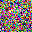

412


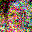

1732


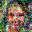

3908


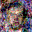

11280


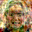

27152


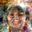

48912


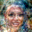

100000


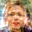

In [207]:
# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 8, dtype=int)
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[:1]
    print(step_slice[i])
    display(to_imgrid((sample_Xtsr * 0.5 + 0.5).clamp(0, 1)))


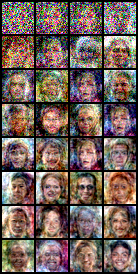

In [214]:
# equidistant sample from step_slice
sample_step_idx = np.linspace(0, len(step_slice)-1, 32, dtype=int)
sample_col = []
for i in sample_step_idx:
    sample_Xmat = sample_store[step_slice[i]]
    sample_Xtsr = sample_Xmat.reshape(-1, *imgshape)[3:4]
    sample_col.append(sample_Xtsr)
sample_col = torch.cat(sample_col, dim=0)
display(to_imgrid((sample_col * 0.5 + 0.5).clamp(0, 1), nrow=4))